# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
import numpy as np

# Cross Entropy

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/10, Train Loss: 0.8118, Accuracy: 0.5042
Epoch 2/10, Train Loss: 0.6956, Accuracy: 0.5034
Epoch 3/10, Train Loss: 0.6935, Accuracy: 0.4900
Epoch 4/10, Train Loss: 0.6971, Accuracy: 0.5993
Epoch 5/10, Train Loss: 0.5279, Accuracy: 0.7631
Epoch 6/10, Train Loss: 0.4810, Accuracy: 0.7873
Epoch 7/10, Train Loss: 0.5221, Accuracy: 0.7640
Epoch 8/10, Train Loss: 0.3473, Accuracy: 0.8601
Epoch 9/10, Train Loss: 0.2655, Accuracy: 0.8935
Epoch 10/10, Train Loss: 0.1818, Accuracy: 0.9335


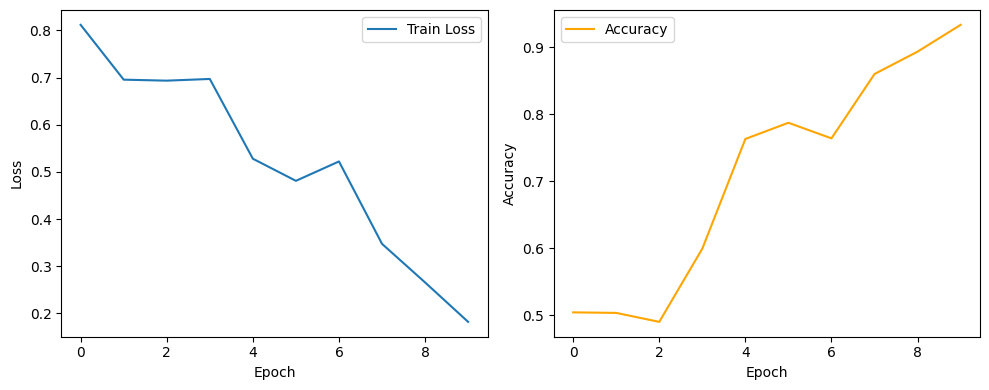

In [25]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedAlexNet, self).__init__()
        # Load the pre-trained AlexNet model
        alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

        # Modify the last fully connected layer for 2 classes
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

        # Initialize the weights of the modified fully connected layer
        self.classifier[-1].weight.data.normal_(0, 0.01)
        self.classifier[-1].bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

    def train_model(self, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
        train_losses = []
        accuracies = []

        for epoch in range(num_epochs):
            # Training
            self.train()
            train_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                _, predicted = outputs.max(1)
                total_samples += labels.size(0)
                correct_predictions += predicted.eq(labels).sum().item()

            accuracy = correct_predictions / total_samples
            accuracies.append(accuracy)

            train_losses.append(train_loss / len(train_loader))
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

        return train_losses, accuracies

    def evaluate(self, data_loader, device='cuda'):
        self.eval()
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = outputs.max(1)
                total_samples += labels.size(0)
                correct_predictions += predicted.eq(labels).sum().item()

        accuracy = correct_predictions / total_samples
        return accuracy

def plot_results(train_losses, accuracies):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    torch.manual_seed(42)

    # Filter the CIFAR-10 dataset for airplanes and automobiles
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Filter dataset for airplanes (class 0) and automobiles (class 1)
    filtered_indices_train = [i for i in range(len(train)) if train.targets[i] in [0, 1]]
    filtered_indices_test = [i for i in range(len(test)) if test.targets[i] in [0, 1]]

    train.data = train.data[filtered_indices_train]
    train.targets = torch.tensor([train.targets[i] for i in filtered_indices_train])

    test.data = test.data[filtered_indices_test]
    test.targets = torch.tensor([test.targets[i] for i in filtered_indices_test])

    # Instantiate the ModifiedAlexNet model and move it to GPU
    model = ModifiedAlexNet(num_classes=2).to(device)

    # Use CrossEntropyLoss and Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #

    # Create data loaders
    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=True)

    # Train the model
    train_losses, accuracies = model.train_model(train_loader, criterion, optimizer, num_epochs=10, device=device)

    # Plot the results
    plot_results(train_losses, accuracies )


In [26]:
test_accuracy = model.evaluate(test_loader, device=device)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9150


# Triplet for feature extraction - Cross Entropy for classifier

In [2]:
class TripletCIFAR10Dataset(Dataset):
    def __init__(self, root, train=True, download=False):
        super().__init__()
        self.transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        dataset = datasets.CIFAR10(root='./data', train=True, transform=self.transform, download=True)

        filtered_indices = [i for i in range(len(dataset)) if dataset.targets[i] in [0, 1]]
        dataset.data = [self.transform(dataset.data[i]) for i in filtered_indices]
        dataset.targets = torch.tensor([dataset.targets[i] for i in filtered_indices])

        self.data = dataset.data
        self.targets = dataset.targets

        self.size = len(dataset)
        self.filtered_indices_0 = [i for i in range(len(self.targets)) if self.targets[i] == 0]
        self.filtered_indices_1 = [i for i in range(len(self.targets)) if self.targets[i] == 1]

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        anchor, anchor_label = self.data[index], self.targets[index]

        # Select a positive example with the same label as the anchor
        positive_index = random.choice(self.filtered_indices_0 if anchor_label == 0 else self.filtered_indices_1)
        positive = self.data[positive_index]

        # Select a negative example with a different label from the anchor
        negative_label = random.choice([label for label in [0, 1] if label != anchor_label])
        negative_index = random.choice(self.filtered_indices_0 if negative_label == 0 else self.filtered_indices_1)
        negative = self.data[negative_index]

        return anchor, positive, negative

# Load CIFAR-10 dataset and filter for airplanes and automobiles
triplet_dataset = TripletCIFAR10Dataset(root='./data2', train=True, download=True)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epochs:  25%|██▌       | 1/4 [00:34<01:44, 34.80s/it]

Epoch: 1/4 - Loss: 0.7851


Epochs:  50%|█████     | 2/4 [01:07<01:07, 33.64s/it]

Epoch: 2/4 - Loss: 0.2439


Epochs:  75%|███████▌  | 3/4 [01:40<00:33, 33.22s/it]

Epoch: 3/4 - Loss: 0.1516


Epochs: 100%|██████████| 4/4 [02:13<00:00, 33.35s/it]

Epoch: 4/4 - Loss: 0.1177


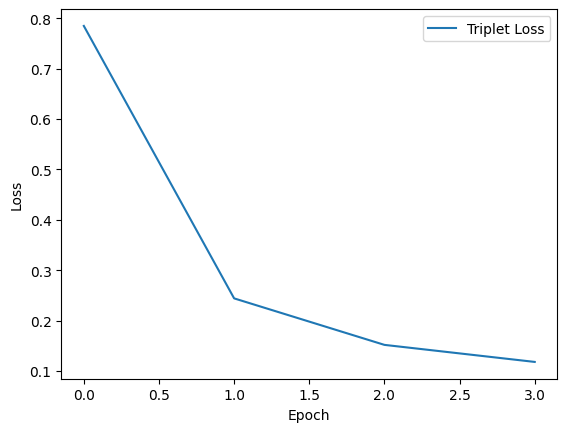

Files already downloaded and verified
Epoch 1/10, Train Loss: 0.0510, Accuracy: 0.9852
Epoch 2/10, Train Loss: 0.0219, Accuracy: 0.9936
Epoch 3/10, Train Loss: 0.0189, Accuracy: 0.9930
Epoch 4/10, Train Loss: 0.0171, Accuracy: 0.9941
Epoch 5/10, Train Loss: 0.0132, Accuracy: 0.9952
Epoch 6/10, Train Loss: 0.0116, Accuracy: 0.9946
Epoch 7/10, Train Loss: 0.0134, Accuracy: 0.9943
Epoch 8/10, Train Loss: 0.0120, Accuracy: 0.9959
Epoch 9/10, Train Loss: 0.0113, Accuracy: 0.9954
Epoch 10/10, Train Loss: 0.0091, Accuracy: 0.9970


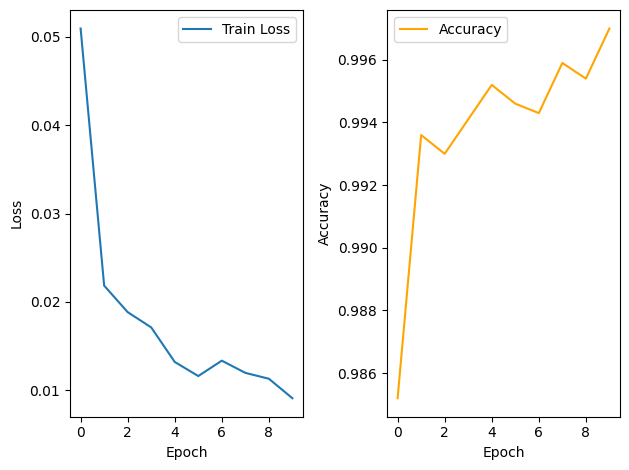

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModifiedAlexNet(nn.Module):
    def __init__(self, embedding_size=256):
        super(ModifiedAlexNet, self).__init__()
        # Load the pre-trained AlexNet model
        alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

        # Remove the last fully connected layer and add a new one for embeddings
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.embedding_layer = nn.Linear(256 * 6 * 6, embedding_size)

        # Initialize the weights of the modified embedding layer
        self.embedding_layer.weight.data.normal_(0, 0.01)
        self.embedding_layer.bias.data.zero_()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

        # Initialize the weights of the modified fully connected layer
        self.classifier[-1].weight.data.normal_(0, 0.01)
        self.classifier[-1].bias.data.zero_()

    def train_features(self):
        for param in self.features.parameters():
          param.requires_grad = True

    def train_fc(self):
      for param in self.features.parameters():
          param.requires_grad = False

    def forward(self, x, train_feature):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if not train_feature:
          x = self.classifier(x)
        return x

    def train_model_features(self, train_loader, optimizer, criterion, num_epochs=10, device='cuda'):
        losses = []
        self.train()
        self.train_features()
        for epoch in tqdm(range(num_epochs), desc="Epochs"):
          running_loss = []
          for step, (anchor_img, positive_img, negative_img) in enumerate(train_loader):
              anchor_img = anchor_img.to(device)
              positive_img = positive_img.to(device)
              negative_img = negative_img.to(device)

              optimizer.zero_grad()
              anchor_out = self(anchor_img, train_feature=True)
              positive_out = self(positive_img, train_feature=True)
              negative_out = self(negative_img, train_feature=True)

              loss = criterion(anchor_out, positive_out, negative_out)
              loss.backward()
              optimizer.step()

              running_loss.append(loss.cpu().detach().numpy())
          losses.append(np.mean(np.array(running_loss)))
          print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, num_epochs, np.mean(np.array(running_loss))))

        return losses


    def train_model_fc_layers(self, train_loader, criterion, optimizer, num_epochs=10, device="cuda"):
        train_losses = []
        accuracies = []
        self.train()
        self.train_fc()
        for epoch in range(num_epochs):
            train_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs, False)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                _, predicted = outputs.max(1)
                total_samples += labels.size(0)
                correct_predictions += predicted.eq(labels).sum().item()

            accuracy = correct_predictions / total_samples
            accuracies.append(accuracy)

            train_losses.append(train_loss / len(train_loader))
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

        return train_losses, accuracies

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Calculate Euclidean distances
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)

        # Calculate triplet loss
        loss = F.relu(pos_dist - neg_dist + self.margin)

        return loss.mean()

if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the ModifiedAlexNet model and move it to GPU
    model = ModifiedAlexNet().to(device)

    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = TripletLoss()

    # Train the model on GPU using triplet loss
    triplet_loader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)
    triplet_losses = model.train_model_features(triplet_loader, optimizer, criterion, num_epochs=4, device=device)

    # Plot the results
    plt.plot(triplet_losses, label='Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Filter the CIFAR-10 dataset for airplanes and automobiles
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Filter dataset for airplanes (class 0) and automobiles (class 1)
    filtered_indices_train = [i for i in range(len(train)) if train.targets[i] in [0, 1]]

    train.data = train.data[filtered_indices_train]
    train.targets = torch.tensor([train.targets[i] for i in filtered_indices_train])

    # Use CrossEntropyLoss and Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # Create data loaders
    train_loader = DataLoader(train, batch_size=64, shuffle=True)

    # Train the model
    train_losses, accuracies = model.train_model_fc_layers(train_loader, criterion, optimizer, num_epochs=10, device=device)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter dataset for airplanes (class 0) and automobiles (class 1)
filtered_indices_test = [i for i in range(len(test)) if test.targets[i] in [0, 1]]

test.data = test.data[filtered_indices_test]
test.targets = torch.tensor([test.targets[i] for i in filtered_indices_test])

test_loader = DataLoader(test, batch_size=64, shuffle=True)

model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

for inputs, labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs, False)
  loss = criterion(outputs, labels)

  test_loss += loss.item()

  _, predicted = outputs.max(1)
  total_samples += labels.size(0)
  correct_predictions += predicted.eq(labels).sum().item()

accuracy = correct_predictions / total_samples
accuracies.append(accuracy)

print(f"test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

Files already downloaded and verified
test Loss: 2.8508, Accuracy: 0.9775


# Total loss: Triplet + Cross Entropy

In [2]:
class TripletCIFAR10DatasetWithLabel(Dataset):
    def __init__(self, root, train=True, download=False):
        super().__init__()
        self.transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((224, 224)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        dataset = datasets.CIFAR10(root='./data', train=True, transform=self.transform, download=True)

        filtered_indices = [i for i in range(len(dataset)) if dataset.targets[i] in [0, 1]]
        dataset.data = [self.transform(dataset.data[i]) for i in filtered_indices]
        dataset.targets = torch.tensor([dataset.targets[i] for i in filtered_indices])

        self.data = dataset.data
        self.targets = dataset.targets

        self.size = len(dataset)
        self.filtered_indices_0 = [i for i in range(len(self.targets)) if self.targets[i] == 0]
        self.filtered_indices_1 = [i for i in range(len(self.targets)) if self.targets[i] == 1]

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        anchor, anchor_label = self.data[index], self.targets[index]

        # Select a positive example with the same label as the anchor
        positive_index = random.choice(self.filtered_indices_0 if anchor_label == 0 else self.filtered_indices_1)
        positive = self.data[positive_index]

        # Select a negative example with a different label from the anchor
        negative_label = random.choice([label for label in [0, 1] if label != anchor_label])
        negative_index = random.choice(self.filtered_indices_0 if negative_label == 0 else self.filtered_indices_1)
        negative = self.data[negative_index]

        return anchor, positive, negative, anchor_label

# Load CIFAR-10 dataset and filter for airplanes and automobiles
triplet_dataset = TripletCIFAR10DatasetWithLabel(root='./data', train=True, download=True)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Calculate Euclidean distances
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)

        # Calculate triplet loss
        loss = F.relu(pos_dist - neg_dist + self.margin)

        return loss.mean()

class ModifiedAlexNet(nn.Module):
    def __init__(self, embedding_size=256):
        super(ModifiedAlexNet, self).__init__()
        # Load the pre-trained AlexNet model
        alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

        # Remove the last fully connected layer and add a new one for embeddings
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.embedding_layer = nn.Linear(256 * 6 * 6, embedding_size)

        # Initialize the weights of the modified embedding layer
        self.embedding_layer.weight.data.normal_(0, 0.01)
        self.embedding_layer.bias.data.zero_()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

        # Initialize the weights of the modified fully connected layer
        self.classifier[-1].weight.data.normal_(0, 0.01)
        self.classifier[-1].bias.data.zero_()


        # loss modules
        self.triplet_loss = TripletLoss(margin=0.2)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def train_model(self, train_loader, optimizer, num_epochs=20, device="cuda"):
        train_losses = []
        accuracies = []
        self.train()
        for epoch in range(num_epochs):
            train_loss = 0.0
            correct_predictions = 0
            total_samples = 0
            for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):

              anchor_img = anchor_img.to(device)
              positive_img = positive_img.to(device)
              negative_img = negative_img.to(device)
              anchor_label = anchor_label.to(device)

              optimizer.zero_grad()
              anchor_out = self(anchor_img)
              positive_out = self(positive_img)
              negative_out = self(negative_img)

              loss = self.triplet_loss(anchor_out, positive_out, negative_out)
              loss += self.ce_loss(anchor_out, anchor_label)
              train_loss += loss.item()
              loss.backward()
              optimizer.step()

              _ , predicted = anchor_out.max(1)
              total_samples += anchor_label.size(0)
              correct_predictions += predicted.eq(anchor_label).sum().item()

            accuracy = correct_predictions / total_samples
            accuracies.append(accuracy)
            train_losses.append(train_loss / len(train_loader))

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

        return train_losses, accuracies

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/5, Train Loss: 0.2010, Accuracy: 0.9589
Epoch 2/5, Train Loss: 0.0895, Accuracy: 0.9856
Epoch 3/5, Train Loss: 0.0515, Accuracy: 0.9924
Epoch 4/5, Train Loss: 0.0316, Accuracy: 0.9949
Epoch 5/5, Train Loss: 0.0377, Accuracy: 0.9934


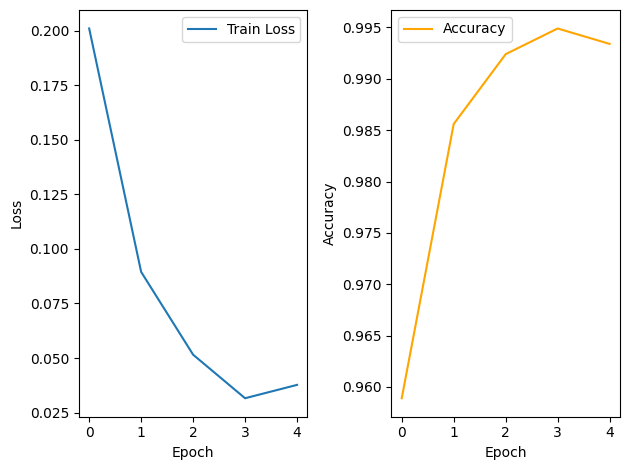

In [18]:
if __name__ == "__main__":
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the ModifiedAlexNet model and move it to GPU
    model = ModifiedAlexNet().to(device)

    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    triplet_loader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)

    # Train the model
    train_losses, accuracies = model.train_model(triplet_loader, optimizer, num_epochs=5, device=device)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter dataset for airplanes (class 0) and automobiles (class 1)
filtered_indices_test = [i for i in range(len(test)) if test.targets[i] in [0, 1]]

test.data = test.data[filtered_indices_test]
test.targets = torch.tensor([test.targets[i] for i in filtered_indices_test])

test_loader = DataLoader(test, batch_size=64, shuffle=True)

model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0

for inputs, labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)

  _, predicted = outputs.max(1)
  total_samples += labels.size(0)
  correct_predictions += predicted.eq(labels).sum().item()

accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy:.4f}")

Files already downloaded and verified
Accuracy: 0.9755
